CS235 Project - Fall 2024
- Alex Cupps (acupp002)
- Zach Schwartz (zschw004)

In [70]:
#Cell reserved for all needed imports
import numpy as np
import pandas as pd
import math
from collections import Counter
from sklearn.metrics import classification_report, make_scorer, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt

Before we begin to analyze our data, we must first load it from the .data file provided, along with assigning the column names for the respective features:

In [71]:
columns = ['ID',
           'Diagnosis',
           'radius1',
           'texture1',
           'perimeter1',
           'area1',
           'smoothness1',
           'compactness1',
           'concavity1',
           'concave_points1',
           'symmetry1',
           'fractal_dimension1',
           'radius2',
           'texture2',
           'perimeter2',
           'area2',
           'smoothness2',
           'compactness2',
           'concavity2',
           'concave_points2',
           'symmetry2',
           'fractal_dimension2',
           'radius3',
           'texture3',
           'perimeter3',
           'area3',
           'smoothness3',
           'compactness3',
           'concavity3',
           'concave_points3',
           'symmetry3',
           'fractal_dimension3'
           ]

data = pd.read_csv('data/wdbc.data', header=None, sep=',', names=columns)

print(data.head())


         ID Diagnosis  radius1  texture1  perimeter1   area1  smoothness1  \
0    842302         M    17.99     10.38      122.80  1001.0      0.11840   
1    842517         M    20.57     17.77      132.90  1326.0      0.08474   
2  84300903         M    19.69     21.25      130.00  1203.0      0.10960   
3  84348301         M    11.42     20.38       77.58   386.1      0.14250   
4  84358402         M    20.29     14.34      135.10  1297.0      0.10030   

   compactness1  concavity1  concave_points1  ...  radius3  texture3  \
0       0.27760      0.3001          0.14710  ...    25.38     17.33   
1       0.07864      0.0869          0.07017  ...    24.99     23.41   
2       0.15990      0.1974          0.12790  ...    23.57     25.53   
3       0.28390      0.2414          0.10520  ...    14.91     26.50   
4       0.13280      0.1980          0.10430  ...    22.54     16.67   

   perimeter3   area3  smoothness3  compactness3  concavity3  concave_points3  \
0      184.60  2019.0  

1. Implementing simple classifiers [15pts]
- What to implement: In this question you should implement (1) a decision tree classifier
that uses the Information Gain splitting criterion and (2) a Naive Bayes classifier which uses
Gaussian modeling for continuous features.
- What to plot: You should produce a bar-chart that shows the performance of your classifiers
on the dataset.


We will be creating a decision tree classifier using the information gain splitting criterion to effectively utilize the feature at each node that provides us with the most information gain about our target feature, 'Diagnosis' - telling us whether or not a breast mass is malignant (M) or benign (B). 
<br><br>
First, we must prepare the data for the decision tree. First, we will drop the ID column and data from our dataset, as this data is not relevant to our predictive model. Next, we will create two new variables:
1. features - the data for all features in our dataset other than the target
2. target - the target feature of our dataset (Diagnosis) - determining whether a tumor is benign or malignant. We will convert the diagnosis data from categorical to numerical for the decision tree classifier.

In [72]:
if 'ID' in data.columns:
    data = data.drop(columns=['ID'])
    
features = data.drop(columns=['Diagnosis']).values
target = data['Diagnosis'].map({'M': 1, 'B': 0}).values

Next, we will create a function 'calculate_entropy' that takes the various values in the dataset and calculate the entropy, or level of purity.

In [73]:
def calculate_entropy(x):
    counts = np.bincount(x)
    probabilities = counts / len(x)
    entropy = 0

    for prob in probabilities:
        if prob > 0:
            entropy += prob * abs(np.log2(prob))

    return entropy

Now that we have our entropy calculation completed, we need to create a function for calculating information gain. Since our features are mainly continuous, we should not perform exact value splits - doing so would lead to many small (and mostly single-item) bins, which would result in overfitting of our model. Instead, we will come up with thresholds between values for our splitting.

In [74]:
def calculate_information_gain(dataset, labels, feature):
    
    #sort the indexes of the dataset for the given feature
    sorted = np.argsort(dataset[:, feature])

    #apply the sorting to the feature data and labels
    sorted_data = dataset[sorted]
    sorted_labels = labels[sorted]

    #start at the top, calculating entropy level of the dataset
    #to determine the level of purity
    parent_entropy = calculate_entropy(labels)

    #iterate over possible thresholds and get the indexes on each side
    top_info_gain = 0
    top_threshold = None
    for i in range(1, len(sorted_data)):

        threshold = (sorted_data[i-1, feature] + sorted_data[i, feature]) / 2
        #left split is a boolean array containing True for the indexes with a value less than the threshold
        #right split is a boolean array containing True for the indexes with a value greater than or equal to the threshold
        left_split = sorted_data[:, feature] < threshold
        right_split = sorted_data[:, feature] >= threshold

        #next we calculate the entropies for the left and right sides of the split
        #this will tell us how effective the split is, and we will maximize information gain
        left_split_entropy = calculate_entropy(sorted_labels[left_split])
        right_split_entropy = calculate_entropy(sorted_labels[right_split])

        #calculate the weights of the left and right splits for use in the overall weight entropy calculation
        weight_l = np.sum(left_split) / len(sorted_data)
        weight_r = np.sum(right_split) / len(sorted_data)

        #calculate the overall weighted entropy of the current split
        weighted_split_entropy = weight_l * left_split_entropy + weight_r * right_split_entropy

        #using the weighted split entropy, calculate the information gain of the threshold
        #if the information gain is higher than any we've come across thus far, set as the top one
        information_gain = parent_entropy - weighted_split_entropy
        if information_gain > top_info_gain:
            top_info_gain = information_gain
            top_threshold = threshold

    return top_info_gain, top_threshold

Now that we've created our functions to calculate entropy and weighted information gain, we will create the Decision Tree Classifier itself. First, we need to create a Node class to store various attributes (feature index, threshold, left of threshold values, right of threshold values) of the node we are evaluating:

In [75]:
class TreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):

        #feature: index of feature being used for split
        self.feature = feature

        #threshold: threshold for the split
        self.threshold = threshold

        #left: the left node, contains all values < threshold
        self.left = left

        #right: the right node, contains all values >= threshold
        self.right = right

        #value: value (0 or 1 for benign or malignant) assigned when a leaf node is reached
        #remains None until leaf node is found, then returns the value
        self.value = value

    def leaf_node_reached(self):
        if self.value is not None:
            return True
        else:
            return False

Next, we will create our DecisionTreeClassifier class. This object contains all relevant methods for building our decision tree, recursively building tree nodes and calculating/maximizing information gain. I've annotated each method below with comments on its purpose: 

In [76]:
class DecisionTreeClassifier:
    def __init__(self, maximum_tree_depth):

        #maximum_tree_depth (int): the maximum depth for our tree
        self.maximum_tree_depth = maximum_tree_depth

        self.tree = None

    def fit(self, dataset, labels):
        #method containing all logic to train our classifier
        self.tree = self.build_tree(dataset, labels)

    def build_tree(self, dataset, labels, cur_tree_depth=0):
        #this method is where the bulk of the work is handled for building our decision tree

        #label count gives us the number of labels in the current sample set
        #label count of 1 indicates perfect purity (one of our stopping criteria)
        label_ct = len(np.unique(labels))

        #we first check our stoppage criteria, to see if we've reached a leaf node
        #if our current depth has hit the stoppage depth defined, OR
        #if the label count has a value of 1
        if cur_tree_depth >= self.maximum_tree_depth or label_ct == 1:
            # Return a leaf node with the most common class label
            leaf_value = self.get_top_label(labels)
            return TreeNode(value=leaf_value)

        #call get_top_split() to calculate the top feature and threshold
        top_feature, top_threshold = self.get_top_split(dataset, labels)
        if top_feature is None:
            #no feature being returned indicates we've reached a leaf node
            #return this TreeNode object with the leaf value found
            leaf_value = self.get_top_label(labels)
            return TreeNode(value=leaf_value)

        #split data on top feature and threshold
        #then build the sub trees off using this split
        left_split = dataset[:, top_feature] < top_threshold
        right_split = dataset[:, top_feature] >= top_threshold
        left_sub_tree = self.build_tree(dataset[left_split], labels[left_split], cur_tree_depth + 1)
        right_sub_tree = self.build_tree(dataset[right_split], labels[right_split], cur_tree_depth + 1)

        return TreeNode(feature=top_feature, threshold=top_threshold, left=left_sub_tree, right=right_sub_tree)

    def get_top_split(self, dataset, labels):

        feature_ct = dataset.shape[1]
        top_feature = None
        top_threshold = None
        top_info_gain = 0

        #iterate over the features and determine which feature/threshold provide the highest information gain
        for feature in range(feature_ct):
            info_gain, threshold = calculate_information_gain(dataset, labels, feature)
            if info_gain > top_info_gain:
                top_info_gain = info_gain
                top_feature = feature
                top_threshold = threshold

        return top_feature, top_threshold

    def get_top_label(self, labels):
        #returns the most common label in the array
        #we call this function to determine whether benign or malignant samples are more prominent
        return np.bincount(labels).argmax()

    def predict(self, dataset):
        predictions = []
        for point in dataset:
            #append the predicted label value to our predictions list
            predictions.append(self.predict_datapoint(point, self.tree))
        return np.array(predictions)

    def predict_datapoint(self, point, node):
        #first check if we've reached a leaf node
        #if so, return the determined label value
        if node.leaf_node_reached():
            return node.value
        
        #if not leaf value, continue down the left or right tree nodes
        if point[node.feature] < node.threshold:
            return self.predict_datapoint(point, node.left)
        else:
            return self.predict_datapoint(point, node.right)

    #required getter and setter functions for our object 
    def get_params(self, deep=True):
        return {"maximum_tree_depth": self.maximum_tree_depth}

    def set_params(self, maximum_tree_depth=None):
        self.maximum_tree_depth = maximum_tree_depth
        return self

To create the naive bayes classifer, data preprocessing first gets done to ensure only relevant data is utilized.  The ID feature will not be relevant in predicting the Diagnosis and gets dropped from the dataset.  Encoding our target variable turns the output to numeric values, making it easier to identify within this classifier.  The data set next has a 75/25 training and testing split to help the classifier learn before it gets tested.  

In [77]:
data_df = pd.DataFrame(data)
print(f"Initial Look into Target Column {data_df['Diagnosis'].head()}")

#Dropping Irrelevant ID column
if 'ID' in data_df.columns:
    data_df = data_df.drop(columns=['ID'])


 
#Label Encoding for Diagnosis
data_df['Diagnosis Encoding'] = pd.factorize(data_df['Diagnosis'])[0]
data_df['Diagnosis Encoding']=data_df['Diagnosis Encoding'].add(1)

#Malignant will show up as '1' AND Benign as '2'
print(f"Verification that encoding works: {data_df['Diagnosis Encoding'].head()}")
data_df = data_df.drop('Diagnosis', axis = 1)

#Splitting Data
train_data = data_df.sample(frac=0.75, random_state = 42)
test_data = data_df.drop(train_data.index)
x_train = train_data.drop("Diagnosis Encoding", axis = 1)
x_test = test_data.drop("Diagnosis Encoding", axis = 1)
y_train = train_data['Diagnosis Encoding']
y_test = test_data['Diagnosis Encoding']


print(data_df.columns)



Initial Look into Target Column 0    M
1    M
2    M
3    M
4    M
Name: Diagnosis, dtype: object
Verification that encoding works: 0    1
1    1
2    1
3    1
4    1
Name: Diagnosis Encoding, dtype: int64
Index(['radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1',
       'compactness1', 'concavity1', 'concave_points1', 'symmetry1',
       'fractal_dimension1', 'radius2', 'texture2', 'perimeter2', 'area2',
       'smoothness2', 'compactness2', 'concavity2', 'concave_points2',
       'symmetry2', 'fractal_dimension2', 'radius3', 'texture3', 'perimeter3',
       'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3',
       'symmetry3', 'fractal_dimension3', 'Diagnosis Encoding'],
      dtype='object')


The two main classes for our given dataset is Benign and Malignant.  Naive Bayes makes the assumption that features are independent given a class label.  Because the intention is to predict likelihood on whether new data belongs to a specific class, the training dataset gets defined by whether our target variable (Diagnosis) gives a 1 or 2.  From the class dataset, the mean and variance methods are defined in preparation for the Gaussian probability function.  This method calculates the probability of each feature in a data sample/instance based on Gaussian distribution.  Traditional computation would combine these probabilites through finding their product.  Finding the logarithmic summation was done instead due to logarithmic function's ability to handle smaller values better.  Additionally, any values of zero that could be found in variance were redefined as a miniscule number 1E-12 to avoid possibility of diving by zero.  This same concept was applied to the probability of a feature value being found in a class

In [78]:
#Separating the data by class 
class Benign:
    #Having benign data be instance method allows method to call on itself
    def benign_data(self, x_train, y_train):
        x_train_b = x_train[y_train == 2]
        return x_train_b
    def mean(self, x_train_b):
        mean_value = {}
        #Calculating mean of the numerical features in dataset
        for column in x_train_b.select_dtypes(exclude ='object'):
            mean_value[column] = x_train_b[column].mean()
        return mean_value
    def variance(self, x_train_b):
        variance = {}
        #Calculating variance of numerical features in databset
        for column in x_train_b.select_dtypes(exclude ='object'):
            #Recording the variance value for each individual feature
            variance[column] = x_train_b[column].var()
        return variance
    #Probability calculation requires parameters of class data set, index being called plus pre-calculated mean & variance
    def gaussianProbability(self, x_train_b, index, mean,variance):     
        #Defining the probability sum before loop so function can add up all probabilities through each run in loop
        sum_logP = 0
        for column in x_train_b.select_dtypes(exclude ='object'):
            #After parsing through a feature, x captures the data sample/instance within index that is called
            x = x_train_b.loc[index,column]
            μ = mean[column]
            σ = variance[column]
            #Handling zero values to avoid breaking Gaussian Probability calculation
            if σ == 0:
                σ = 1E-12
            if μ ==0:
                μ = 1E-12
            #Setting up Naive Bayes proability calculation on continuous features by splitting numerator and denominator
            #Assumes dataset has a Gaussian Distribution
            num = math.exp(-(x-μ)**2/(2*σ))
            denom = math.sqrt(2 * math.pi * σ)
            P = num/denom
            #Ensuring probability will not get too close to 0
            if P <= 0:
                P = 1E-18
            #Using summation o
            #Using summation of log function over product of posterior probability since log handles small numbers better
            logP= (math.log(P))
            #Variable increases the count of logP
            sum_logP += logP
        return sum_logP


class Malignant:
    def malignant_data(self, x_train, y_train):
        x_train_m = x_train[y_train == 1]
        return x_train_m
    
    def mean(self, x_train_m):
        mean_value = {}
        #Calculating mean of the numerical features in dataset
        for column in x_train_m.select_dtypes(exclude ='object'):
            mean_value[column] = x_train_m[column].mean()
        return mean_value
    def variance(self, x_train_m):
        variance = {}
        #Calculating variance of numerical features in databset
        for column in x_train_m.select_dtypes(exclude ='object'):
            #Recording the variance value for each individual feature
            variance[column] = x_train_m[column].var()
        return variance
    #Probability calculation requires parameters of class data set, index being called plus pre-calculated mean & variance
    def gaussianProbability(self, x_train_m, index, mean,variance):     
        #Defining the probability sum before loop so function can add up all probabilities through each run in loop
        sum_logP = 0
        for column in x_train_m.select_dtypes(exclude ='object'):
            #After parsing through a feature, x captures the data sample/instance within index that is called
            x = x_train_m.loc[index,column]
            μ = mean[column]
            σ = variance[column]
            #Handling zero values to avoid breaking Gaussian Probability calculation
            if σ == 0:
                σ = 1E-12
            if μ ==0:
                μ = 1E-12
            #Setting up Naive Bayes proability calculation on continuous features by splitting numerator and denominator
            #Assumes dataset has a Gaussian Distribution
            num = math.exp(-(x-μ)**2/(2*σ))
            denom = math.sqrt(2 * math.pi * σ)
            P = num/denom 
            #Ensuring probability will not get too close to 0
            if P <= 0:
                P = 1E-18
            #Using summation of log function over product of conditional probabilities since log handles small numbers better
            logP= (math.log(P))
            #Variable increases the count of logP
            sum_logP += logP
        return sum_logP
    


Next, we create a NaiveBayesClassifier object to help us classify our data samples as benign or malignant. Below is a breakdown of the class:

- init(): initialize the object
- fit(): the method for training our NB classifier. In this method, we calculate the prior probabilities for both malignant and benign label values. We then train the classifier based off of these prior beliefs, and calculate the mean and variance values for both the malignant and benign labels.
- predict(): in this method, we compute the actual prediction value of the label for a given row of data in our test split dataset. We calculate the Gaussian probability for each class label (B vs. M). Whichever one is higher is the predictive value we assign to the data.
- get_params() / set_params(): allows for getting and setting of the object's values dynamically. These two methods are required in order to work with SKLearn's cross_val_score function that we utilize in order to calculate the performance of our model (without these two methods, errors are thrown when trying to call the function).


In [79]:
class NaiveBayesClassifier:
    def __init__(self, priors=None):
        self.benign = Benign()
        self.malignant = Malignant()
        self.priors = priors if priors is not None else {}

    def fit(self, x_train, y_train):
        n_total = len(y_train)
        n_benign = np.sum(y_train == 2)
        n_malignant = np.sum(y_train == 1)

        self.priors['benign'] = n_benign / n_total
        self.priors['malignant'] = n_malignant / n_total

        # Fit the Benign and Malignant models using the training data
        self.x_train_b = self.benign.benign_data(x_train, y_train)
        self.mean_b = self.benign.mean(self.x_train_b)
        self.variance_b = self.benign.variance(self.x_train_b)

        self.x_train_m = self.malignant.malignant_data(x_train, y_train)
        self.mean_m = self.malignant.mean(self.x_train_m)
        self.variance_m = self.malignant.variance(self.x_train_m)

    def predict(self, x_test):
        predictions = []

        for index in x_test.index:
            #Compute probabilities, and assign the predicted class of 2 (benign) or 1 (malignant)
            #depending on which probability is higher
            gauss_test_B = self.benign.gaussianProbability(x_test, index, self.mean_b, self.variance_b)
            gauss_test_M = self.malignant.gaussianProbability(x_test, index, self.mean_m, self.variance_m)
            pred_class = 2 if gauss_test_B > gauss_test_M else 1
            predictions.append(pred_class)

        return np.array(predictions)

    def get_params(self, deep=True):
        return {'priors': self.priors}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self


Now that we've created our decision tree and naive bayes classifiers, we will begin the process of testing the performance and analyzing our results. Below, we've created two functions:

1. test_performance() - this function has two arguments, X (the data matrix) and y (the label values). 
2. get_f1() - a helper function called by our test_performance function. This function takes four arguments - the data matrix and label values passed in from test_performance, along with the stratified k fold and classifier objects we've created. We return sklearn's cross_val_score call on our parameters, which returns an array containing the f1 scores at each fold in the cross validation.

In [80]:
def test_performance(classifier, X, y):
    kfold = StratifiedKFold(n_splits=10, shuffle=True)
    f1_scores = get_f1(X, y, kfold, classifier)

    mean_f1_scores = np.mean(f1_scores)
    stdev_f1_scores = np.std(f1_scores)

    return mean_f1_scores, stdev_f1_scores

def get_f1(X, y, skf, classifier):
    return cross_val_score(classifier, X, y, cv=skf, scoring=make_scorer(f1_score, average='weighted'))

Once we've built our performance calculating functions, we want to plot our results. We call test_performance, and get the mean and standard deviation values of our f1 scores at each fold, for both of our classifiers. With these two values, we build up a plot to show each classifier's performance, along with the levels of error:

Decision Tree F1 Mean: 0.9263568654460661
Decision Tree F1 Std. Dev.: 0.030476804047124512
Naive Bayes F1 Mean: 0.9061435777844448
Naive Bayes F1 Std. Dev.: 0.06037445683747495


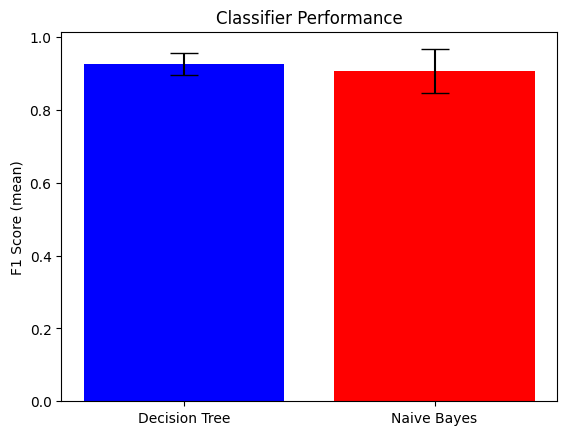

In [81]:
def plot_performance(classifier_names, mean_f1, std_f1):
    fig, ax = plt.subplots()
    ax.bar(classifier_names, mean_f1, yerr=std_f1, color=['blue', 'red'], capsize=10)
    ax.set_ylabel('F1 Score (mean)')
    ax.set_title('Classifier Performance')
    plt.show()

dec_tree_mean_f1, dec_tree_std_f1 = test_performance(
    DecisionTreeClassifier(maximum_tree_depth=5), 
    features, 
    target)

nb_mean_f1, nb_std_f1 = test_performance(
    NaiveBayesClassifier(), 
    x_test, y_test)

print(f"Decision Tree F1 Mean: {dec_tree_mean_f1}")
print(f"Decision Tree F1 Std. Dev.: {dec_tree_std_f1}")
print(f"Naive Bayes F1 Mean: {nb_mean_f1}")
print(f"Naive Bayes F1 Std. Dev.: {nb_std_f1}")

classifier_names = ["Decision Tree", "Naive Bayes"]
f1_means = [dec_tree_mean_f1, nb_mean_f1]
f1_stds = [dec_tree_std_f1, nb_std_f1]

plot_performance(classifier_names, f1_means, f1_stds)

Based on these results, we can see that the decision tree classifier has roughly a 93% mean F1 score, which indicates our classifier is effectively handling our imbalanced dataset and considering false positives and false negatives. The low standard deviation (roughly 0.03) tells us that the classifier is avoiding overfitting the data and performing well across the ten folds.  

Naive Bayes is able to achieve a mean F1 score of 0.9061, which reveals that this classifier effectively handles the dataset.  Since the F1 tests false positive and negatives, the higher score suggests that this classifier has a minimal chance of error.  The small standard deviation of 0.0603744 shows that the classifier's performance is consistent with minimal variance.  This avoids overfitting and boosts confidence in ability to handle foreign datasets.

Feature Selection with Randomization

20% of dataset is used to randomly shuffle all features
80% dataset is untouched and used for testing at the end

In [82]:
#Creating a copy of original dataset for random permutation

#Method that loops through all columns and randomly permutates each feature
def permutatingData(data):
    random_perm_data = data.copy()
    for column in random_perm_data:
        if column !='Diagnosis':
            random_perm_data[column] = np.random.permutation(random_perm_data[column])
    return random_perm_data

#Validating that method above works
print(f"Original dataset is: \n {data.head()}")
rp_data = permutatingData(data)
print(f"Permutated dataset is: \n {rp_data.head()}")

Original dataset is: 
   Diagnosis  radius1  texture1  perimeter1   area1  smoothness1  compactness1  \
0         M    17.99     10.38      122.80  1001.0      0.11840       0.27760   
1         M    20.57     17.77      132.90  1326.0      0.08474       0.07864   
2         M    19.69     21.25      130.00  1203.0      0.10960       0.15990   
3         M    11.42     20.38       77.58   386.1      0.14250       0.28390   
4         M    20.29     14.34      135.10  1297.0      0.10030       0.13280   

   concavity1  concave_points1  symmetry1  ...  radius3  texture3  perimeter3  \
0      0.3001          0.14710     0.2419  ...    25.38     17.33      184.60   
1      0.0869          0.07017     0.1812  ...    24.99     23.41      158.80   
2      0.1974          0.12790     0.2069  ...    23.57     25.53      152.50   
3      0.2414          0.10520     0.2597  ...    14.91     26.50       98.87   
4      0.1980          0.10430     0.1809  ...    22.54     16.67      152.20   

   

Splitting the datset to set up for model training.  As detailed in the instructions, one of the model trainings will follow our standard dataset while the second one incorporates 20% stratified random sampling and the remaining 80% for testing will consist purely of the original dataset.  In order to keep data consistent with the classifiers written from scratch, encoding of the target feature Diagnosis was applied on the randomly permutated dataset.  

In [83]:
#Feature selection on the 20% stratified random sample of entire dataset

#Turning the randomly permutated datset into a dataframe for easy data splitting
rp_dataDF = pd.DataFrame(rp_data)

#Adding encoding feature to keep randomly stratified data consistent with original dataset
print(f"Initial Look into Target Column: \n {rp_dataDF['Diagnosis'].head()}")
rp_dataDF['Diagnosis Encoding'] = pd.factorize(rp_dataDF['Diagnosis'])[0]
rp_dataDF['Diagnosis Encoding']=rp_dataDF['Diagnosis Encoding'].add(1)
print(f"Verification that encoding works: \n{rp_dataDF['Diagnosis Encoding'].head()}")
#Malignant will show up as 1 AND Benign as 2

#Training and Testing Data Split
train_data_R = rp_dataDF.sample(frac=0.2, random_state = 41)
test_data_R = data_df.sample(frac = 0.8, random_state = 41)
x_train_R = train_data_R.drop(columns = ['Diagnosis Encoding'])
x_test_R = test_data_R.drop(columns = ['Diagnosis Encoding'])
y_train_R = train_data_R['Diagnosis Encoding']
y_test_R = test_data_R['Diagnosis Encoding']

Initial Look into Target Column: 
 0    M
1    M
2    M
3    M
4    M
Name: Diagnosis, dtype: object
Verification that encoding works: 
0    1
1    1
2    1
3    1
4    1
Name: Diagnosis Encoding, dtype: int64


Below is where we start training the model with data containing randomized features.  We start off by using Decision Tree classifier and then employ the Naive Bayes classifer

In [92]:
#Using fit method established earlier to help train both classifiers
model_dt= DecisionTreeClassifier(maximum_tree_depth=5)
model_nb = NaiveBayesClassifier


#model_dt.fit(x_train_R, y_train_R)
#model_dt.build_tree(x_train_R, y_train_R, cur_tree_depth=0)
#model_nb.fit(x_train_R, y_train_R)

#Redefining test performance method with 5-fold cross validation
def test_performance2(classifier, X, y):
    kfold = StratifiedKFold(n_splits=5, shuffle=True)
    f1_scores = get_f1(X, y, kfold, classifier)

    mean_f1_scores = np.mean(f1_scores)
    stdev_f1_scores = np.std(f1_scores)

    return mean_f1_scores, stdev_f1_scores

#Validation still in progress
#dt_mean_f1, dt_std_f1 = test_performance(
    #DecisionTreeClassifier(maximum_tree_depth=5), x_test_R, y_test_R)
nB_mean_f1, nB_std_f1 = test_performance(
    NaiveBayesClassifier(), x_test_R, y_test_R)


